# Challenge Summary

I trea cloud qubit as a blak box and we tried to simplify the problem as mutch as possible since we have acces onl;y to the input and output i mada not gata a gate that change state |0> in |1> ans |1> in |0> up to some scalr (-|1> and |1> and j|a> will give me the same output). But sign in front of the excited state cam be coreeste in the future with an unexpensive Z gate. For H i made a gate that change my state of qubit from |0> to 1/sqrt(2)(|0>+ |1>) idealy wold be to also ty to apply H on the state 1 that was create with the pulse not pulse put We mismanaged our time .

Firs We  thought at the beggining about how to create a cost function. We decide that we will use proprity of a dot product :
For X gate if we apply in an od number of time we will mouve from state |0> in state |1> wit probabiliy 100 so the desire outcome y_desire=[0,1,0].If we apply it an od number of time we XX=I so we remain in state |0> y_desire=[1,0,0]. For the H gate since we alweys start feom the state |0> for an od number of repetition y_desire=[0.5,0.5,0] (this is not a statevector is the main diagonal of density matrix) and for even we are in the same situation. 

Next step was to creat some parametize pulse and here we have spent a lot of time figuring out how to get a pulse for X gate.

To simplify thinks evem more we ommited imaginary since X and H don't have imagginary part and we have time constrains with model training.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize

from qctrlvisualizer import get_qctrl_style, plot_controls
from qctrl import Qctrl

qctrl = Qctrl(email='', password='')

In [39]:
# genrate data for a gaussian pulse 
def gaussian_pulse(t, mean, width):
        return np.exp(-0.5 * ((t - mean) / width) ** 2.0) * np.sqrt(
            0.5 * np.pi / width ** 2.0)
    
def get_pulse(mean,width,segment_count):
    pulse=[]
    for i in range(0,segment_count):
        p=gaussian_pulse(t=i*segmentsize+segmentsize/2, mean=mean, width=width)
        pulse.append(p)
    return pulse 

Here we have an example fro a pulse similar with the one used for best H

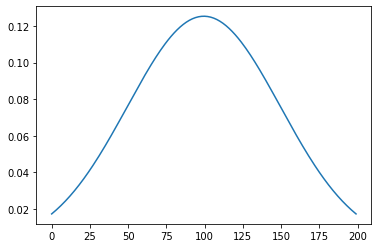

In [32]:
#initial parameters

segment_count=200
duration=40
width=duration/4
mean=duration/2
segmentsize=duration/segment_count
amplitude=0.5

pulse=get_pulse(mean,width,segment_count)
plt.plot(pulse)

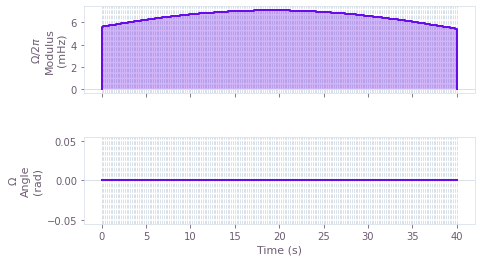

In [40]:
real_part = pulse#np.random.random(size=[segment_count])
imag_part = np.random.random(size=[segment_count])
values = amplitude * (real_part + 1j * imag_part*0)
control={"duration": duration, "values": values}
# Plot the last control as an example.
plot_controls(
    figure=plt.figure(),
    controls={
        "$\Omega$": [
            {"duration": duration / segment_count, "value": value} for value in values
        ]
    },
)

For X gate we observe that is hurd to put the qubit in |1> state. The think that excite your qubit is the energi and and ennery is proportional withe the are uner the graph so we decide to use two gaussian:

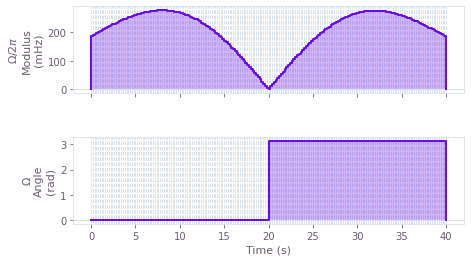

In [49]:
segment_count=200
# values from a good pulse 
amplitude1= 15.49724215#duration/4
amplitude2= -15.42531197#duration/4
width1=duration/4#25.56953712
width2=duration/4#26.86006445
mean1=duration/4
mean2=duration-mean1

segmentsize=duration/segment_count

pulse1=get_pulse(mean1,width1,segment_count)
pulse2=get_pulse(mean2,width2,segment_count)
pulse=pulse=[pulse2[i]-pulse1[i] for i in range (len(pulse1))]

values = np.array([amplitude1 * (pulse1[i] + 1j*0)+amplitude2 * (pulse2[i] + 1j *0)for i in range (len(pulse1))])

control={"duration": duration, "values": values}
# Plot the last control as an example.
plot_controls(
    figure=plt.figure(),
    controls={
        "$\Omega$": [
            {"duration": duration / segment_count, "value": value} for value in values
        ]
    },
)

Now even with such simplification we have some parameters that we can verry but we wil start to optimize just over amplitudes and width. We also made a lot of duration optimization by hand in pricipal we din't whant to have a long duration beacuse this will affect the nr of gates that we can ad in a qubit life time. Also wold be indicate to incees segment counts.

## Building the cost function for H

### !!  To ghet our resukt ve star first with just repetitions=[1,2,3] and after eatch minimisation me add another ser of rpetition. In the var-H youu can follow the messy procedure that we followed.

Here we have just one amlitude and onw with over witch we will optimize.

In [72]:
def cost_h(params):
    
    print('params:',params)
    amplitude=params[0]
    width=params[1]
        
    #
    duration=40
    mean=duration/2
    
    #
    
    segmentsize=duration/segment_count
    
    pulse_real=get_pulse(mean,width,segment_count)
    
    real_part = pulse_real
    imag_part = np.random.random(size=[segment_count])# if first experiments it will be set to 0
    
    values = amplitude * (real_part + 1j * imag_part*0)
    
    repetitions=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
    controls=[]
    for repetition_count in repetitions:
        controls.append({"duration": duration, "values": values, "repetition_count": repetition_count})
        experiment_results = qctrl.functions.calculate_qchack_measurements(controls=controls,shot_count=shot_count,)


    cost=0
    for repetition_count, measurement_counts in zip(repetitions, experiment_results.measurements):
        p0 = measurement_counts.count(0) / shot_count
        p1 = measurement_counts.count(1) / shot_count
        p2 = measurement_counts.count(2) / shot_count
        y_genrate=[p0,p1,p2]
        if  repetition_count%2==1:
            y_desire=[0.5,0.5,0]
            c=np.array(y_desire) @ np.array(y_genrate)
            cost=cost-c
        else:
            y_desire=[1,0,0]
            c=np.array(y_desire) @ np.array(y_genrate)
            cost=cost-c

        print(f"With {repetition_count:2d} repetitions: P(|0>) = {p0:.2f}, P(|1>) = {p1:.2f}, P(|2>) = {p2:.2f} ,c={c:.3f} .")
    
    print('Cost:',cost)
    return cost 

For cost_x check var-x.ipynb .

## Optimization:

In [87]:
# H gate:

shot_count = 250 
params=[ 4.03658917 ,28.45216669]  

cobyla_options = {'maxiter': 1, 'disp': True, 'catol': 0.002} # here we reduce the nr of iterations because this is just for the sake of an exampl 
res = scipy.optimize.minimize(cost_h, params, method='COBYLA',options=cobyla_options)
params_h=res['x']
print(params_h)

params: [ 4.03658917 28.45216669]


100%|██████████| 100/100 [00:09<00:00, 10.01it/s]

With  1 repetitions: P(|0>) = 0.58, P(|1>) = 0.42, P(|2>) = 0.00 ,c=0.500 .
With  2 repetitions: P(|0>) = 1.00, P(|1>) = 0.00, P(|2>) = 0.00 ,c=1.000 .
With  3 repetitions: P(|0>) = 0.61, P(|1>) = 0.39, P(|2>) = 0.00 ,c=0.500 .
With  4 repetitions: P(|0>) = 0.99, P(|1>) = 0.01, P(|2>) = 0.00 ,c=0.992 .
With  5 repetitions: P(|0>) = 0.57, P(|1>) = 0.43, P(|2>) = 0.00 ,c=0.500 .
With  6 repetitions: P(|0>) = 0.97, P(|1>) = 0.03, P(|2>) = 0.00 ,c=0.972 .
With  7 repetitions: P(|0>) = 0.50, P(|1>) = 0.50, P(|2>) = 0.00 ,c=0.500 .
With  8 repetitions: P(|0>) = 1.00, P(|1>) = 0.00, P(|2>) = 0.00 ,c=1.000 .
With  9 repetitions: P(|0>) = 0.56, P(|1>) = 0.44, P(|2>) = 0.00 ,c=0.500 .
With 10 repetitions: P(|0>) = 0.98, P(|1>) = 0.02, P(|2>) = 0.00 ,c=0.984 .
With 11 repetitions: P(|0>) = 0.60, P(|1>) = 0.40, P(|2>) = 0.00 ,c=0.500 .
With 12 repetitions: P(|0>) = 0.99, P(|1>) = 0.01, P(|2>) = 0.00 ,c=0.992 .
With 13 repetitions: P(|0>) = 0.60, P(|1>) = 0.40, P(|2>) = 0.00 ,c=0.500 .
With 14 repe

Obs: for reps%2==0 the value of c can be maximum 0.5 [0.5,0.5,0][0.5,0.5,0]=0.25+0.25=0.5
     for reps%2==1 the value of c can be maximum 1

This method can be generalize to more complex gates if we change the cost function and we decide to use more complex pulse structure.